# Investigating the relation between cost and spike train smoothing and evalulation window

A few things don't make sense in the previous notebook. 

I think, partly, it may be to do with:

* large discretisation effect in the approximation of cost gradient
* correlated spike trains have a non trivial effect on the cost function that neither FD or RD can remove. Indeed, does one want to remove these effects if correlations effect the cost function 'landscape'?

These both need to be investigated.

## Discretization effect

This can be reduced by taking the cost function evaluation over a larger window, or possibly by smoothing the output spike train, or both.

### Smoothing output spike train

Let's examine the cost function/spike dependence when we smooth.

We import some simulations from before

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from pandas.plotting import autocorrelation_plot as autocorr
import pandas as pd

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect, causaleffect_linear

dt = 0.001         #Step size
t = 10             #Simulation time
tr = 0.003         #Refractory period
mu = 1             #Threshold
reset = 0          #Reset potential
xsigma = 1         #Std dev of input x
n = 2              #Number of neurons
tau = 1            #Time constant
c = .99            #Correlation between noise inputs
sigma = 20         #Std dev of noise process

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load simulations and compute different average cost functions
N = 20
nsims = 500
c = 0.99
wmax= 20

fn_in = './sweeps/param_w_N_%d_nsims_%d_c_%f_default_simulations.npz'%(N, nsims, c)
sims = np.load(fn_in)

hs = sims['hs']
vs = sims['vs']
wvals = sims['wvals']

#30ms of filter
tau_s = 0.020
dt = 0.001

How do we smooth?

In [72]:
i = 3;
j = 3;

h1 = hs[i,j,:,0,:]
v1 = vs[i,j,:,0,:]
h2 = hs[i,j,:,1,:]
v2 = vs[i,j,:,1,:]

s1 = np.zeros(h1.shape)
s2 = np.zeros(h2.shape)

t_filter = np.linspace(0, 0.06, 60)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)

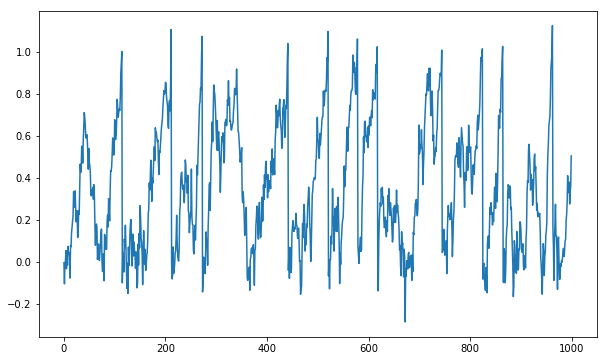

In [73]:
plt.plot(v1[0,0:1000])

0.052038773303004472

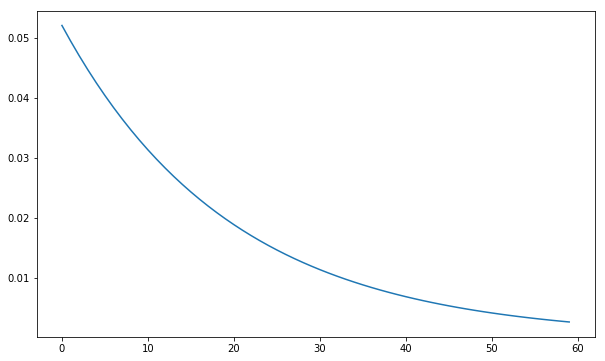

In [74]:
plt.plot(exp_filter)
ds = exp_filter[0]
ds

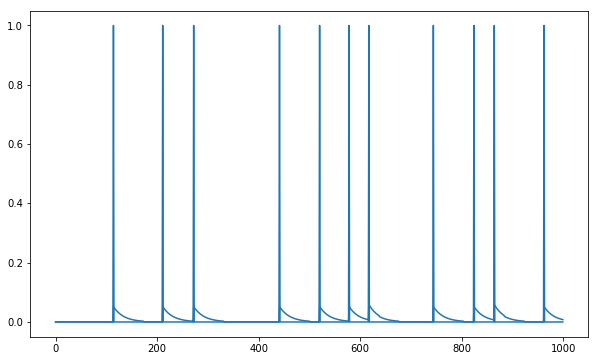

In [75]:
#Sample spike train
h1.shape
s1 = np.convolve(h1[0,:], exp_filter)
s2 = np.convolve(h2[0,:], exp_filter)
fig, ax = plt.subplots(1,1)
ax.plot(h1[0,0:1000], 'C0')
ax.plot(s1[0:1000])

Looks good.

Ok, so how does this effect the 'causal effect'?

In [120]:
v1.shape

(500, 10000)

-7.8398462131047211

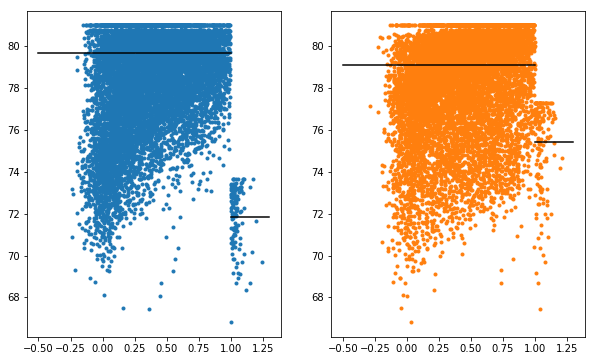

In [61]:
#Find a spike train
i = 3;
j = 3;

h1 = hs[i,j,:,0,:]
v1 = vs[i,j,:,0,:]
h2 = hs[i,j,:,1,:]
v2 = vs[i,j,:,1,:]

l = 20;

s1 = np.zeros(h1.shape)
s2 = np.zeros(h2.shape)

t_filter = np.linspace(0, 0.06, 60)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)

x=3

V1 = 8
V2 = 4

#Compute a cost function
cost_h = (V1*h1[0,:]+V2*h2[0,:]-x**2)**2

len_h = h1.shape[1]

s1 = np.convolve(h1[l,:], exp_filter)[0:len_h]
s2 = np.convolve(h2[l,:], exp_filter)[0:len_h]

cost_s = (V1*s1+V2*s2-x**2)**2

#Compute the causal effect
p = 0.01
abv = (v1[l,:]>mu) & (v1[l,:]<(mu+p))
blo = (v1[l,:]<mu) & (v1[l,:]>(mu-p))
C_abv = cost_s[abv]
C_blo = cost_s[blo]
mu_1_blo = np.mean(C_blo)
mu_1_abv = np.mean(C_abv)

abv = (v2[l,:]>mu) & (v2[l,:]<(mu+p))
blo = (v2[l,:]<mu) & (v2[l,:]>(mu-p))
C_abv = cost_s[abv]
C_blo = cost_s[blo]
mu_2_blo = np.mean(C_blo)
mu_2_abv = np.mean(C_abv)

#Make a graph
#fig, (ax1, ax2) = plt.subplots(1,2)
#ax1.plot(v1[0,:], cost_h, '.C0')
#ax2.plot(v2[0,:], cost_h, '.C1')

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(v1[l,:], cost_s, '.C0')
ax2.plot(v2[l,:], cost_s, '.C1');

xlt = np.array([-0.5, 1])
xgt = np.array([1, 1.3])

ax1.plot(xlt, mu_1_blo*np.ones(xlt.shape), color=(0,0,0))
ax1.plot(xgt, mu_1_abv*np.ones(xgt.shape), color=(0,0,0))
ax2.plot(xlt, mu_2_blo*np.ones(xlt.shape), color=(0,0,0))
ax2.plot(xgt, mu_2_abv*np.ones(xgt.shape), color=(0,0,0))

mu_1_abv-mu_1_blo


In [49]:
hs.shape

(20, 20, 500, 2, 10000)

In [63]:
V1 = 8
V2 = 4

pvals = np.linspace(0.01, 1, 20)

beta_rd_w = np.zeros((nsims, n))
beta_fd_w = np.zeros((nsims,n))

m_beta_rd_w = np.zeros((len(pvals),n))
m_beta_fd_w = np.zeros((len(pvals),n))
m_beta_bp_w = np.zeros((n))

se_beta_rd_w = np.zeros((len(pvals),n))
se_beta_fd_w = np.zeros((len(pvals),n))

params = ParamsLIF()
c2_filtered = np.zeros((nsims, hs.shape[4]))

idx = 3
j = 3

len_h = hs.shape[4]

for i,p in enumerate(pvals):
    for k in range(nsims):
        s1 = np.convolve(hs[idx,j,k,0,:], exp_filter)[0:len_h]
        s2 = np.convolve(hs[idx,j,k,1,:], exp_filter)[0:len_h]
        c2_filtered[k,:] = (V1*s1 + V2*s2 - x**2)**2
        beta_rd_w[k,:] = causaleffect(vs[idx,j,k,:,:], c2_filtered[k,:], p, params)
        #print(beta_rd_w)[k,:]
        beta_fd_w[k,:] = causaleffect(vs[idx,j,k,:,:], c2_filtered[k,:], 1, params)
    m_beta_rd_w[i,:] = np.mean(beta_rd_w, 0)
    m_beta_fd_w[i,:] = np.mean(beta_fd_w, 0)
    se_beta_rd_w[i,:] = np.std(beta_rd_w, 0)
    se_beta_fd_w[i,:] = np.std(beta_fd_w, 0)
    
m_beta_bp_w[0] = (V1**2)*(ds**2) + 2*V1*V2*np.mean(s2)*ds-2*V1*(x**2)*ds
m_beta_bp_w[1] = (V2**2)*(ds**2) + 2*V1*V2*np.mean(s1)*ds-2*V2*(x**2)*ds

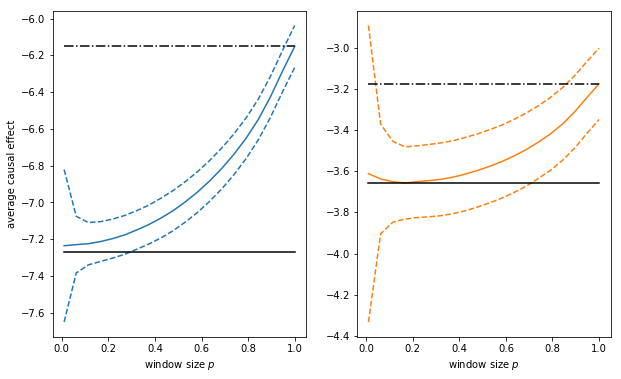

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(pvals, m_beta_rd_w[:,0],'C0')
ax1.plot(pvals, m_beta_rd_w[:,0]+se_beta_rd_w[:,0],'--C0')
ax1.plot(pvals, m_beta_rd_w[:,0]-se_beta_rd_w[:,0],'--C0')
ax1.plot(pvals, m_beta_bp_w[0]*ones(pvals.shape), color=(0,0,0))
ax1.plot(pvals, m_beta_rd_w[-1,0]*ones(pvals.shape), '-.', color=(0,0,0))

ax2.plot(pvals, m_beta_rd_w[:,1],'C1')
ax2.plot(pvals, m_beta_rd_w[:,1]+se_beta_rd_w[:,1],'--C1')
ax2.plot(pvals, m_beta_rd_w[:,1]-se_beta_rd_w[:,1],'--C1')
ax2.plot(pvals, m_beta_bp_w[1]*ones(pvals.shape), color=(0,0,0))
ax2.plot(pvals, m_beta_rd_w[-1,1]*ones(pvals.shape), '-.', color=(0,0,0))

ax1.set_xlabel('window size $p$')
ax1.set_ylabel('average causal effect')
ax2.set_xlabel('window size $p$');

In [94]:
N = 20
costs2 = np.zeros((N,N))
costs2_filtered = np.zeros((N,N))

V1 = 0.5
V2 = 5

p = 0.03

nsims = 50

beta_rd_w = np.zeros((nsims, n))
beta_fd_w = np.zeros((nsims, n))

m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))
m_beta_bp_w = np.zeros((N,N,n))

params = ParamsLIF()
c2_filtered = np.zeros((nsims, hs.shape[4]))

x = 0.1

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*h1 + v2*h2 - x**2)**2
        costs2[i,j] = np.mean(c2)
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:len_h]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:len_h]
            c2_filtered[k,:] = (V1*s1 + V2*s2 - x**2)**2
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], p, params)
        costs2_filtered[i,j] = np.mean(c2_filtered)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)
        m_beta_bp_w[i,j,0] = V1**2*ds**2 + 2*V1*V2*np.mean(s2)*ds-2*V1*x**2*ds
        m_beta_bp_w[i,j,1] = V2**2*ds**2 + 2*V1*V2*np.mean(s1)*ds-2*V2*x**2*ds


W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


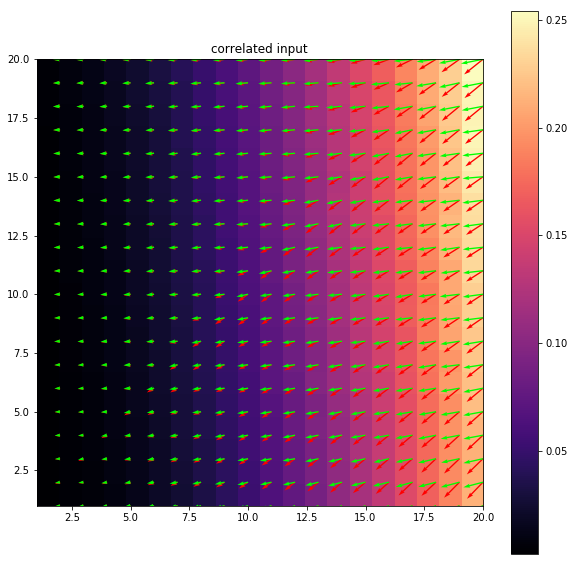

In [95]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = N
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2_filtered, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input')

fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1], -m_beta_fd_w[:,:,0], color=(1, 0, 0))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1], -m_beta_rd_w[:,:,0], color=(0, 1, 0))

In [108]:
N = 20
costs2 = np.zeros((N,N))
costs2_filtered = np.zeros((N,N))

V1 = -5
V2 = 5

p = 0.03

nsims = 50

beta_rd_w = np.zeros((nsims, n))
beta_fd_w = np.zeros((nsims, n))

m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))
m_beta_bp_w = np.zeros((N,N,n))

params = ParamsLIF()
c2_filtered = np.zeros((nsims, hs.shape[4]))

x = 0.1

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*h1 + v2*h2 - x**2)**2
        costs2[i,j] = np.mean(c2)
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:len_h]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:len_h]
            c2_filtered[k,:] = (V1*s1 + V2*s2 - x**2)**2
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], p, params)
        costs2_filtered[i,j] = np.mean(c2_filtered)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)
        m_beta_bp_w[i,j,0] = V1**2*ds**2 + 2*V1*V2*np.mean(s2)*ds-2*V1*x**2*ds
        m_beta_bp_w[i,j,1] = V2**2*ds**2 + 2*V1*V2*np.mean(s1)*ds-2*V2*x**2*ds

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


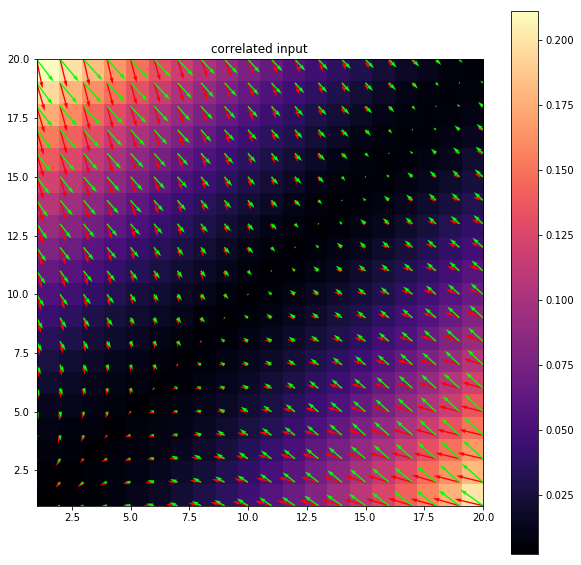

In [109]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = N
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2_filtered, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input')

fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1], -m_beta_fd_w[:,:,0], color=(1, 0, 0))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1], -m_beta_rd_w[:,:,0], color=(0, 1, 0))

In [125]:
N = 20
costs2 = np.zeros((N,N))
costs2_filtered = np.zeros((N,N))

V1 = 3
V2 = 5

p = 0.03

nsims = 50

beta_rd_w = np.zeros((nsims, n))
beta_fd_w = np.zeros((nsims, n))

m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))
m_beta_bp_w = np.zeros((N,N,n))

params = ParamsLIF()
c2_filtered = np.zeros((nsims, hs.shape[4]))

x = 0.1

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*h1 + v2*h2 - x**2)**2
        costs2[i,j] = np.mean(c2)
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:len_h]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:len_h]
            c2_filtered[k,:] = (V1*s1 - 10*x**2)**2+(V2*s2 - 20*x**2)**2
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], p, params)
        costs2_filtered[i,j] = np.mean(c2_filtered)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)
        m_beta_bp_w[i,j,0] = V1**2*ds**2 + 2*V1*V2*np.mean(s2)*ds-2*V1*x**2*ds
        m_beta_bp_w[i,j,1] = V2**2*ds**2 + 2*V1*V2*np.mean(s1)*ds-2*V2*x**2*ds

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


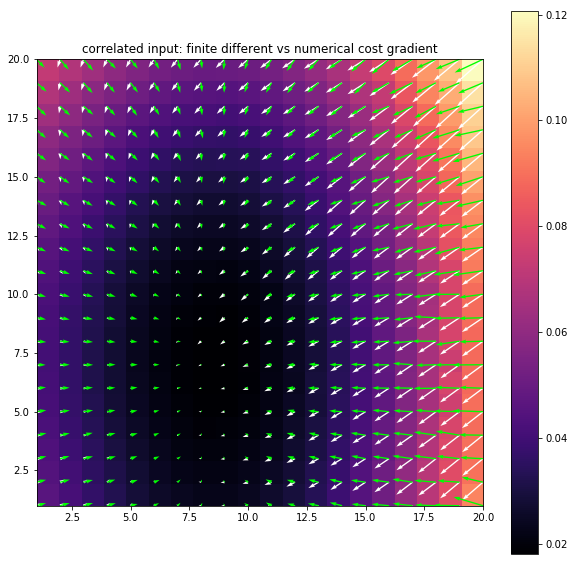

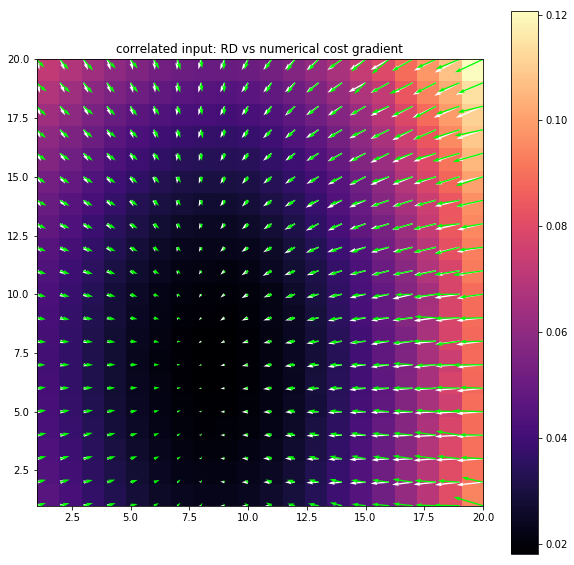

In [128]:
grad = np.gradient(costs2_filtered)

fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = N
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2_filtered, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input: finite different vs numerical cost gradient')

fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1], -m_beta_fd_w[:,:,0], color=(1, 1, 1))
Q = ax1.quiver(X, Y, -grad[1], -grad[0], color=(0, 1, 0))

#Estimate numerical gradient from cost function

fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = N
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2_filtered, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input: RD vs numerical cost gradient')

fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1], -m_beta_rd_w[:,:,0], color=(1, 1, 1))
Q = ax1.quiver(X, Y, -grad[1], -grad[0], color=(0, 1, 0))


In [116]:
N = 20
costs2 = np.zeros((N,N))
costs2_filtered = np.zeros((N,N))

V1 = 5
V2 = 5

p = 0.03

nsims = 2

beta_rd_w = np.zeros((nsims, n))
beta_fd_w = np.zeros((nsims, n))

m_beta_rd_w = np.zeros((N,N,n))
m_beta_fd_w = np.zeros((N,N,n))
m_beta_bp_w = np.zeros((N,N,n))

params = ParamsLIF()
c2_filtered = np.zeros((nsims, hs.shape[4]))

x = 0.1

for i in range(N):
    print("W[0] = %d"%i)
    for j in range(N):
        h1 = hs[i,j,:,0,:]
        h2 = hs[i,j,:,1,:]
        c2 = (v1*h1 + v2*h2 - x**2)**2
        costs2[i,j] = np.mean(c2)
        for k in range(nsims):
            s1 = np.convolve(hs[i,j,k,0,:], exp_filter)[0:len_h]
            s2 = np.convolve(hs[i,j,k,1,:], exp_filter)[0:len_h]
            c2_filtered[k,:] = (V1*s1 - 20*x**2)**2+(V2*s2 - (V1*s1)**2)**2
            beta_fd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], 1, params)
            beta_rd_w[k,:] = causaleffect(vs[i,j,k,:,:], c2_filtered[k,:], p, params)
        costs2_filtered[i,j] = np.mean(c2_filtered)
        m_beta_rd_w[i,j,:] = np.mean(beta_rd_w, 0)
        m_beta_fd_w[i,j,:] = np.mean(beta_fd_w, 0)
        m_beta_bp_w[i,j,0] = V1**2*ds**2 + 2*V1*V2*np.mean(s2)*ds-2*V1*x**2*ds
        m_beta_bp_w[i,j,1] = V2**2*ds**2 + 2*V1*V2*np.mean(s1)*ds-2*V2*x**2*ds

W[0] = 0
W[0] = 1
W[0] = 2
W[0] = 3
W[0] = 4
W[0] = 5
W[0] = 6
W[0] = 7
W[0] = 8
W[0] = 9
W[0] = 10
W[0] = 11
W[0] = 12
W[0] = 13
W[0] = 14
W[0] = 15
W[0] = 16
W[0] = 17
W[0] = 18
W[0] = 19


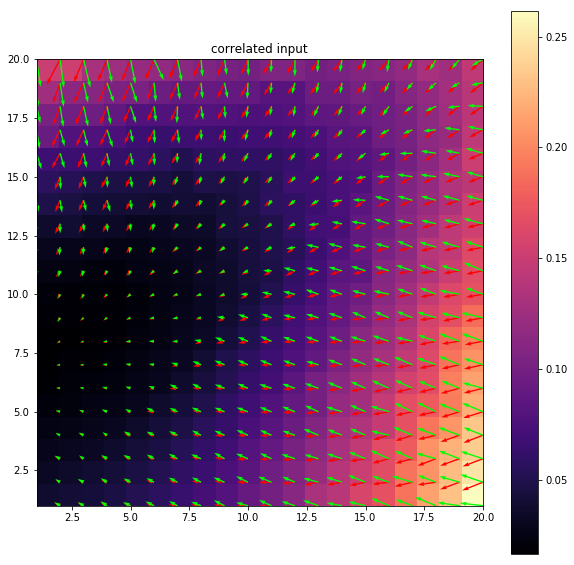

In [117]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,10))
wmax = N
wmin = 1
#a=ax1.contourf(costs2, 30, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
a=ax1.imshow(costs2_filtered, cmap='magma', origin='lower', extent=[wmin, wmax, wmin, wmax])
ax1.set_title('correlated input')

fig.colorbar(a);
N=20
X, Y = np.meshgrid(np.linspace(1,wmax,N), np.linspace(1,wmax,N))
Q = ax1.quiver(X, Y, -m_beta_fd_w[:,:,1], -m_beta_fd_w[:,:,0], color=(1, 0, 0))
Q = ax1.quiver(X, Y, -m_beta_rd_w[:,:,1], -m_beta_rd_w[:,:,0], color=(0, 1, 0))

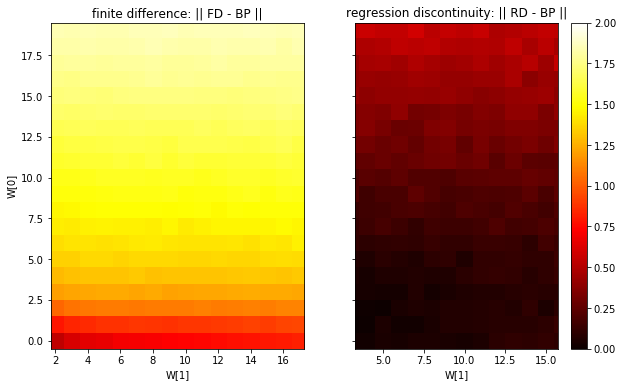

In [70]:
d_fdbp = np.sqrt((m_beta_fd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_fd_w[:,:,1]-m_beta_bp_w[:,:,1])**2)
d_rdbp = np.sqrt((m_beta_rd_w[:,:,0]-m_beta_bp_w[:,:,0])**2 + (m_beta_rd_w[:,:,1]-m_beta_bp_w[:,:,1])**2)

#Plot heat map of error in estimate
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)
a=ax1.imshow(d_fdbp, cmap='hot', origin='lower',vmin=0, vmax=2);
b=ax2.imshow(d_rdbp, cmap='hot', origin='lower',vmin=0, vmax=2);
plt.colorbar(a)

ax1.set_title('finite difference: || FD - BP ||')
ax2.set_title('regression discontinuity: || RD - BP ||')
ax1.set_ylabel('W[0]')
ax1.set_xlabel('W[1]')
ax2.set_xlabel('W[1]');

### How does the theoretical spike rate and the observed spike rate compare?

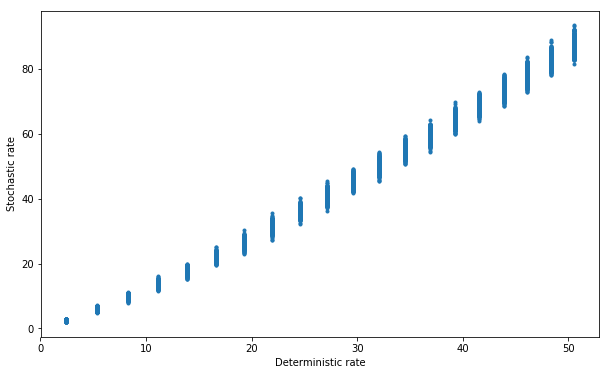

In [49]:
params = ParamsLIF()
tau_r = params.tr
mu = params.mu
sigma = params.xsigma
x = 3
j = 1

nsims = 500

rates = np.zeros(wvals.shape)
h_rates = np.zeros((nsims, len(wvals)))

fig,ax = plt.subplots(1,1)

for i,w in enumerate(wvals):
    rates[i] = (1/(tau_r-tau*np.log(1-mu/(w*sigma*x))))
    h1 = hs[i,j,:,0,:]
    h_rates[:,i] = 1000*np.mean(h1,1)

rates = np.matlib.repmat(rates, nsims, 1)

ax.plot(rates.reshape((-1,1)), h_rates.reshape((-1,)), '.')
ax.set_xlabel('Deterministic rate')
ax.set_ylabel('Stochastic rate')

Pretty well really. Although seemingly off by a factor of 1.6?